In [0]:
#@title Output { vertical-output: true }
from google.colab import drive
drive.mount('/content/gdrive')

#  create symbolic link  /Drivefrom google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
#@title Output { vertical-output: true }
%pwd
%cd /content/gdrive/My\ Drive/04_영상인식_copied/CH9
%pwd

/content/gdrive/My Drive/04_영상인식_copied/CH9


'/content/gdrive/My Drive/04_영상인식_copied/CH9'

## 데이타준비 ( Voc2012  10% )

In [0]:
!rm -rf ./data; mkdir ./data
!tar xf ./VOCdevkit.tar -C ./data

## 데이타 준비 ( Voc2012  100% )

### Download Data

In [0]:
#@title Output { vertical-output: true }
!rm -rf data
!mkdir data
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O data/VOCtrainval_11-May-2012.tar
!wget https://www.dropbox.com/s/oeu149j8qtbs1x0/SegmentationClassAug.zip?dl=0 -O data/SegmentationClassAug.zip


--2019-02-07 04:32:16--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘data/VOCtrainval_11-May-2012.tar’

data/VOCtrainval_11 100%[===================>]   1.86G  45.3MB/s    in 42s     

2019-02-07 04:32:59 (44.9 MB/s) - ‘data/VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2019-02-07 04:33:00--  https://www.dropbox.com/s/oeu149j8qtbs1x0/SegmentationClassAug.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/oeu149j8qtbs1x0/SegmentationClassAug.zip [following]
--2019-02-07 04:33:00

### 압축파일 풀기

In [0]:
#@title Output { vertical-output: true }
!rm -rf data/VOCdevkit
!tar -xf data/VOCtrainval_11-May-2012.tar  --exclude='Annotations' \
         --exclude='ImageSets' --exclude='Segmentation*' -C data
!unzip -q ./data/SegmentationClassAug.zip -d ./data/VOCdevkit/VOC2012 -x *MAC*


### Aug 파일에 맞게 데이타 준비

In [0]:
#@title Output { vertical-output: true }

!mkdir -p ./data/VOCdevkit/VOC2012/JPEGImages/train

!VOC=data/VOCdevkit/VOC2012; \
for idx in $(ls $VOC/SegmentationClassAug/*.png); do \
  mv $VOC/JPEGImages/$(basename $idx .png).jpg $VOC/JPEGImages/train/ ;\
done



### 원본파일과 Segmentation 파일 count

In [0]:
#@title Output { vertical-output: true }
!pwd

!VOC=./data/VOCdevkit/VOC2012; \
 ls $VOC/JPEGImages/train/ | wc -l; \
 ls $VOC/SegmentationClassAug/ |wc -l



/content/gdrive/My Drive/04_영상인식_copied/CH9
ls: cannot access './data/VOCdevkit/VOC2012/JPEGImages/train/': No such file or directory
0
ls: cannot access './data/VOCdevkit/VOC2012/SegmentationClassAug/': No such file or directory
0


## git clone

In [0]:
#@title Output { vertical-output: true }
!git clone https://github.com/Golbstein/Keras-segmentation-deeplab-v3.1 
!cp ./Keras-segmentation-deeplab-v3.1/weights/mobilenetv2_original.h5 ./Keras-segmentation-deeplab-v3.1/weights/mobilenetv2_original_backup.h5



Cloning into 'Keras-segmentation-deeplab-v3.1'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 240
Receiving objects: 100% (243/243), 20.94 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (119/119), done.


## 필수 패키지 설치

In [3]:
!pip install pydensecrf

    100% |████████████████████████████████| 1.0MB 21.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


## 코드 실행

In [4]:
#@title Output { vertical-output: true }
%pwd
%cd ./Keras-segmentation-deeplab-v3.1
%pwd

/content/gdrive/My Drive/04_영상인식_copied/CH9/Keras-segmentation-deeplab-v3.1


'/content/gdrive/My Drive/04_영상인식_copied/CH9/Keras-segmentation-deeplab-v3.1'

In [5]:
#@title Output { vertical-output: true }

%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from keras.optimizers import Adam

image_size = (512, 512) #(512,512) (720, 1280)
bs = 10

better_model = False

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

backbone = 'mobilenetv2' #mobilenetv2, xception

NET = 'deeplab_' + backbone
PATH = '../data/VOCdevkit/VOC2012'

n_classes = len(get_VOC2012_classes()) - 1

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', bs)


SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(bs)

Using TensorFlow backend.


Num workers: 1
Backbone: mobilenetv2
Path to dataset: ../data/VOCdevkit/VOC2012
N classes: 21
Image size: (512, 512)
Batch size: 10


## DeepLab V3+ And a SubPixel Upsampling Layer (better model) or Original

In [6]:
if better_model:
    model = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=True, multi_gpu=False, backbone=backbone)
else:
    model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=True, multi_gpu=False, backbone=backbone)
    
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
print('Weights path:', SegClass.modelpath)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Weights path: weights/mobilenetv2_original.h5


### Train with generator

In [0]:
train_generator = SegClass.create_generators(blur = 5,crop_shape = None, mode = 'train', n_classes = n_classes,
                                             horizontal_flip = True, vertical_flip = False, brightness=0.3, 
                                             rotation=False, zoom=0.1, validation_split = .15, seed = 7, do_ahisteq = False)
valid_generator = SegClass.create_generators(blur = 0, crop_shape = None, mode = 'validation', 
                                             n_classes = n_classes, horizontal_flip = True, vertical_flip = False, 
                                             brightness=.1, rotation=False, zoom=.05, validation_split = .15, 
                                             seed = 7, do_ahisteq = False)

#### fit

In [11]:
monitor = 'Jaccard'
mode = 'max'

# fine-tune model (train only last conv layers)
flag = 0
for k, l in enumerate(model.layers):
    l.trainable = False
    if l.name == 'concat_projection':
        flag = 1
    if flag:
        l.trainable = True
        
def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir='./logs/'+SegClass.net, histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = SegClass.modelpath, verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)
        
SegClass.set_num_epochs(2)
history = SegClass.train_generator(model, train_generator, valid_generator, callbacks, mp = True)


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
99/99 [==============================] - 198s 2s/step - loss: 1.8371 - Jaccard: 0.1613 - sparse_accuracy_ignoring_last_label: 0.6739 - val_loss: 1.1531 - val_Jaccard: 0.3193 - val_sparse_accuracy_ignoring_last_label: 0.8401

Epoch 00001: val_Jaccard improved from -inf to 0.31931, saving model to weights/mobilenetv2_original.h5
Epoch 2/2
99/99 [==============================] - 163s 2s/step - loss: 1.0266 - Jaccard: 0.3914 - sparse_accuracy_ignoring_last_label: 0.8268 - val_loss: 0.7133 - val_Jaccard: 0.4872 - val_sparse_accuracy_ignoring_last_label: 0.8924

Epoch 00002: val_Jaccard improved from 0.31931 to 0.48719, saving model to weights/mobilenetv2_original.h5


### Compare Models

In [0]:
# Load original deeplab and subpixel-deeplab
model1 = SegClass.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model1.load_weights('weights/mobilenetv2_original.h5')
model2 = SegClass.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model2.load_weights('weights/mobilenetv2_original_backup.h5')

In [0]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

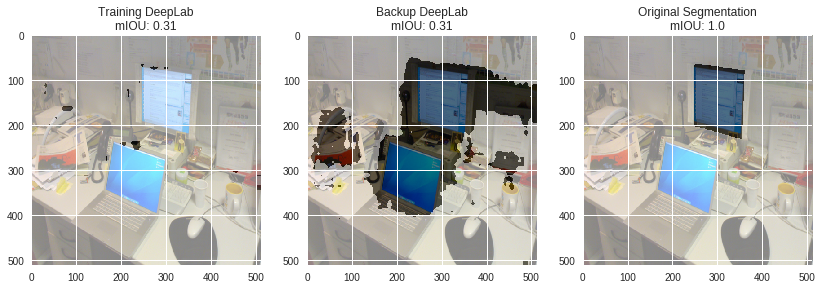

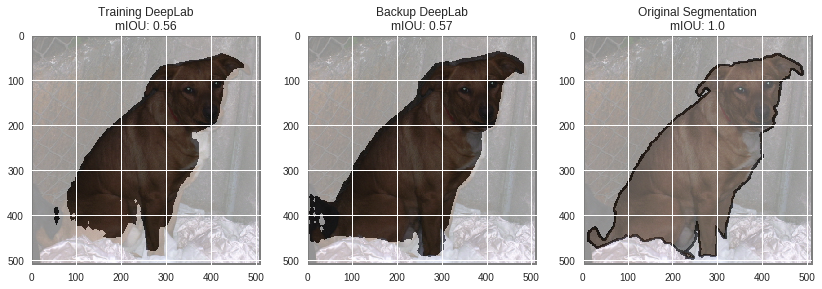

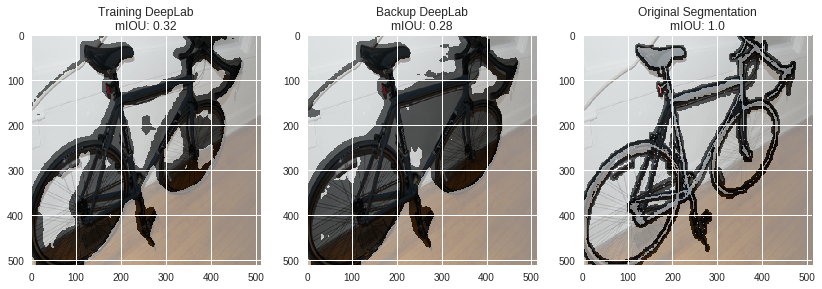

In [14]:
def _predict(i) :
  #i = np.random.randint(0, len(valid_generator))
  x,y,s = valid_generator.__getitem__(i)
  preds1 = np.argmax(model1.predict(x), -1)[0].reshape(image_size)
  preds2 = np.argmax(model2.predict(x), -1)[0].reshape(image_size)

  im = x[0].astype('uint8')
  gt = y[0].reshape(image_size).astype('int32')

  plt.figure(figsize=(14,10))
  
  plt.subplot(131)
  plt.imshow(x[0].astype('uint8'))
  plt.imshow(preds1, alpha=.5)
  plt.title('Training DeepLab\nmIOU: '+str(mIOU(gt, preds1)))
  
  plt.subplot(132)
  plt.imshow(x[0].astype('uint8'))
  plt.imshow(preds2, alpha=.5)
  plt.title('Backup DeepLab\nmIOU: '+str(mIOU(gt, preds2)))
  
  plt.subplot(133)
  plt.imshow(x[0].astype('uint8'))
  plt.imshow(gt, alpha=.5)
  plt.title('Original Segmentation\nmIOU: '+str(mIOU(gt, gt)))
  
for i in np.random.choice(len(valid_generator), 3, replace=False):
  _predict(i)  

## 기타

In [0]:
#model1.summary()
for i in model1.layers :
  a=i.get_weights()
  if len(a) > 0 :
    aa=a[0].shape
  else :
    aa=''
  print( i.name,',', i.trainable, i.output.shape, aa, len(a),'////', type(aa) )